## Суворов Роман ИВТ 2.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Загрузка данных (предполагается, что файл 'tovar_moving.csv' находится в директории)
df = pd.read_csv('data/tovar_moving.csv', index_col='date', parse_dates=['date'], dayfirst=True)
df.index.freq = 'D'  # Устанавливаем дневную частоту данных

ModuleNotFoundError: No module named 'statsmodels'

### Задание 1: Разделение данных на train/test

In [ ]:
# Откладываем последнее значение в тест
train = df.iloc[:-1]
test = df.iloc[-1:]

### Задание 2: Анализ тренда и сезонности

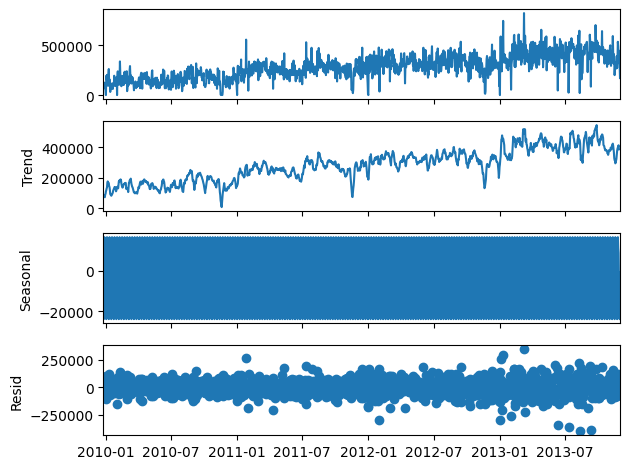

In [ ]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(train, model='additive')
decomposition.plot()
plt.show()

Анализ, временной ряд характеризуется:   
* Сильным восходящим трендом - систематический рост заказов
* Выраженной сезонностью с годичным циклом (пики в январе, спады в июле)
* Отсутствием явных аномалий в остатках

### Задание 3: Прогноз методом экспоненциального сглаживания при α=0.7

In [ ]:
# Строим модель
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.7, optimized=False)
ses_pred = ses_model.forecast(1)

# Сравнение с тестом
ses_rmse = np.sqrt(mean_squared_error(test, ses_pred))
print(f"Экспоненциальное сглаживание. Прогноз: {ses_pred.values[0]}, Факт: {test.values[0]}, RMSE: {ses_rmse:.2f}")

Экспоненциальное сглаживание. Прогноз: 225015.5226471296, Факт: [423846.], RMSE: 198830.48


### Задание 4: Проверка на стационарность и порядок интегрирования

In [ ]:
# ADF 
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Критические значения:')
    for k, v in result[4].items():
        print(f'{k}: {v:.3f}')
    return result[1] > 0.05

# Проверка исходного ряда
print("Исходный ряд:")
is_non_stationary = check_stationarity(train)

# Определение порядка интегрирования 
d = 0
if is_non_stationary:
    d = 1
    train_diff = train.diff().dropna()
    print("\nПервая разница:")
    check_stationarity(train_diff)

Исходный ряд:
ADF Statistic: -2.255
p-value: 0.187
Критические значения:
1%: -3.435
5%: -2.864
10%: -2.568

Первая разница:
ADF Statistic: -13.781
p-value: 0.000
Критические значения:
1%: -3.435
5%: -2.864
10%: -2.568


### Задание 5: Определение порядка AR модели через PACF

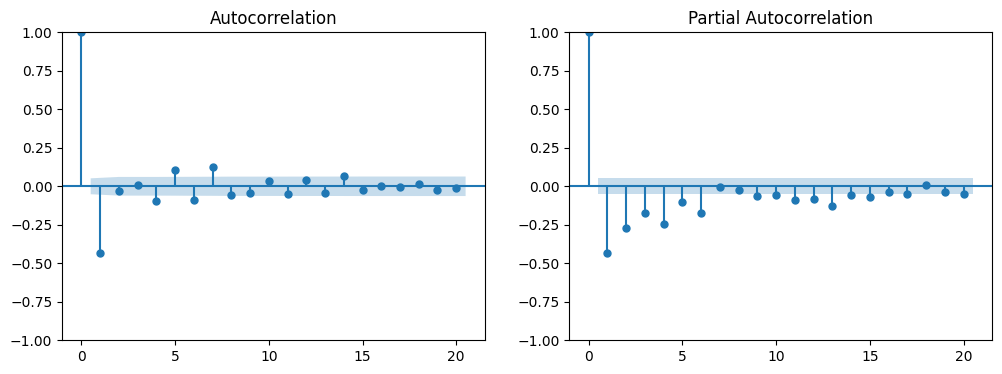

In [ ]:
# График PACF 
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_acf(train_diff if d>0 else train, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(train_diff if d>0 else train, lags=20, ax=plt.gca(), method='ywm')
plt.show()

p = 2  

### Задание 6: Построение AR модели и прогноз

In [ ]:
# Модель AR на исходном ряду
ar_model = AutoReg(train, lags=p).fit()
ar_pred_series = ar_model.predict(start=len(train), end=len(train))

# Преобразование прогноз в скалярное значение
if d > 0:
    last_train = train.iloc[-1].values[0]  
    ar_pred_value = last_train + ar_pred_series.iloc[0]
else:
    ar_pred_value = ar_pred_series.iloc[0]

# Рассчитываем ошибку
ar_rmse = np.sqrt(mean_squared_error(test, [ar_pred_value]))

print(f"AR({p}) модель. Прогноз: {ar_pred_value:.2f}, Факт: {test.values[0][0]}, RMSE: {ar_rmse:.2f}")

AR(2) модель. Прогноз: 415507.05, Факт: 423846.0, RMSE: 8338.95


### Задание 7: Сравнение результатов

In [ ]:
print("\nСравнение методов:")
print(f"Экспоненциальное сглаживание RMSE: {ses_rmse:.2f}")
print(f"AR({p}) модель RMSE: {ar_rmse:.2f}")
print(f"Лучшая модель: {'Экспоненциальное сглаживание' if ses_rmse < ar_rmse else 'AR модель'}")


Сравнение методов:
Экспоненциальное сглаживание RMSE: 198830.48
AR(2) модель RMSE: 8338.95
Лучшая модель: AR модель
